Metal device set to: Apple M1 Pro


2023-10-24 17:39:19.443568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-24 17:39:19.443698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


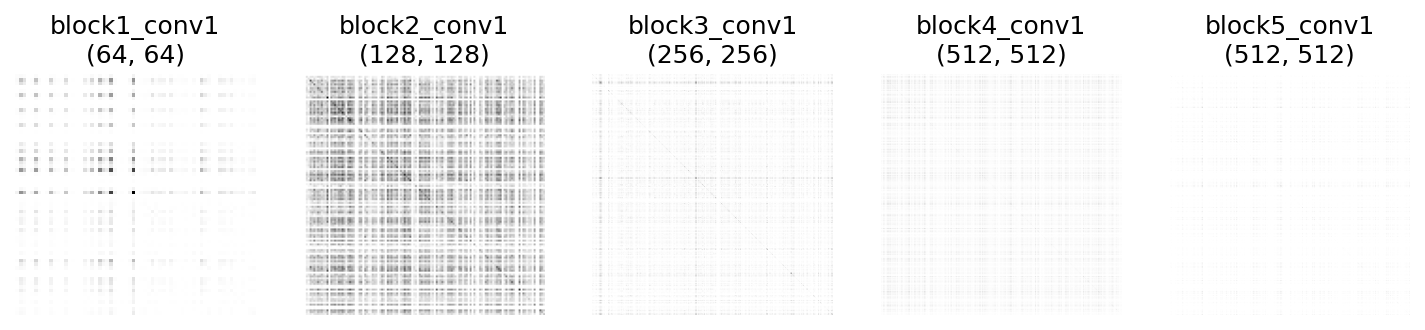

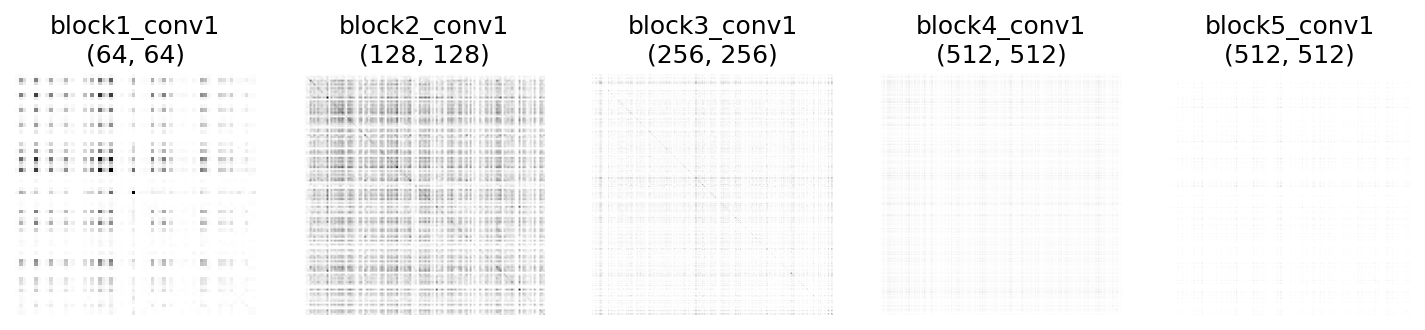

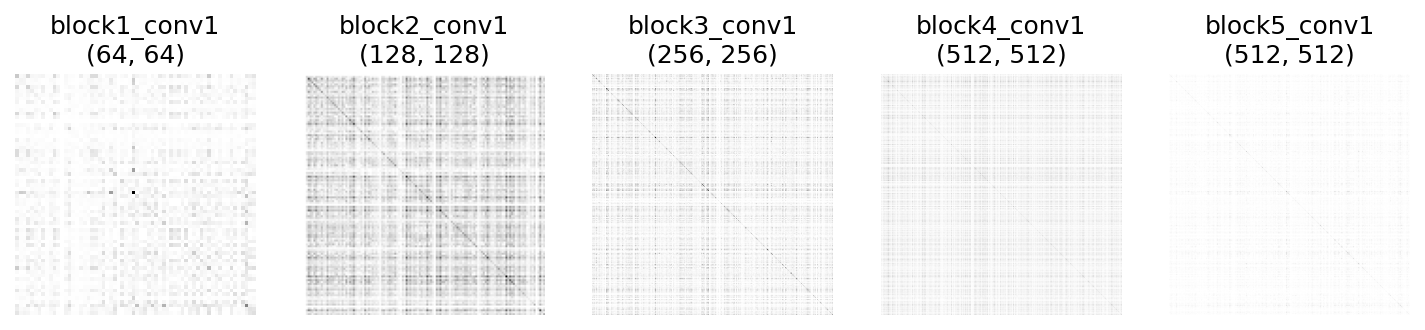

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Load and preprocess the style image
style_images = [ 
    'style_transfer/clouds1.jpg',
    'style_transfer/clouds2.jpg',
    'style_transfer/cat.jpg'
]

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = keras.preprocessing.image.img_to_array(img)
    img = keras.applications.vgg19.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis, :]

    return img

def vgg_style_layers(layer_names):
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = keras.Model([vgg.input], outputs)
    return model

# Calcoliamo il gramiano di una serie di feature map
def gram_matrix(feature):
    # Flatten the feature map
    reshaped_feature = tf.reshape(feature, (feature.shape[1] * feature.shape[2], -1))
    
    # Compute the Gram matrix
    gram = tf.matmul(reshaped_feature, reshaped_feature, transpose_a=True)
    
    return gram

# Define a function to display the style features as heatmaps
def show_style_features(gram_matrices, style_layers):
    num_style_layers = len(style_layers)

    plt.figure(figsize=(12, 12), dpi=150)
    for i in range(num_style_layers):
        plt.subplot(1, num_style_layers, i + 1)
        plt.imshow(gram_matrices[i], cmap='gray_r')
        plt.title(f'{style_layers[i]}\n{gram_matrices[i].shape}')
        plt.axis('off')

    plt.show()


# Layer della VGG dai quali andremo ad estrarre le matrici di gram
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


for style_image_path in style_images:
    style_image = load_and_preprocess_image(style_image_path)
    style_extractor = vgg_style_layers(style_layers)

    # Crea il feature extractor
    style_features = style_extractor(style_image)
    gram_matrices = [gram_matrix(feature) for feature in style_features]


    show_style_features(gram_matrices, style_layers)




In [2]:
 import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained VGG model
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def gram_matrix(feature):
    # Flatten the feature map
    reshaped_feature = tf.reshape(feature, (feature.shape[1] * feature.shape[2], -1))
    
    # Compute the Gram matrix
    gram = tf.matmul(reshaped_feature, reshaped_feature, transpose_a=True)
    
    return gram

# Define a function to extract style from an image
def extract_style(image):
    image = tf.keras.applications.vgg19.preprocess_input(image)
    style_features = style_extractor(image)
    gram_matrices = [gram_matrix(feature) for feature in style_features]
    return gram_matrices

# Define a function to generate an image with the given style
def generate_image_with_style(style_reference, image_size=(224, 224), num_iterations=1000, style_weight=1e3):
    # Initialize a random image as the starting point
    generated_image = tf.Variable(tf.random.uniform(shape=(1, *image_size, 3), minval=0, maxval=255, dtype=tf.float32))
    
    # Define the optimizer
    optimizer = tf.optimizers.Adam(learning_rate=5.0)
    
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            # Extract features from the generated image
            generated_features = style_extractor(generated_image)
            
            # Calculate the style loss
            style_loss = 0
            for generated_feature, style_feature in zip(generated_features, style_reference):
                style_loss += tf.reduce_mean(tf.square(gram_matrix(generated_feature) - style_feature))
            
            # Total loss
            total_loss = style_weight * style_loss
        
        # Calculate gradients and update the generated image
        gradients = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        
        # Clip pixel values to be in the range [0, 255]
        generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))
    
    return generated_image

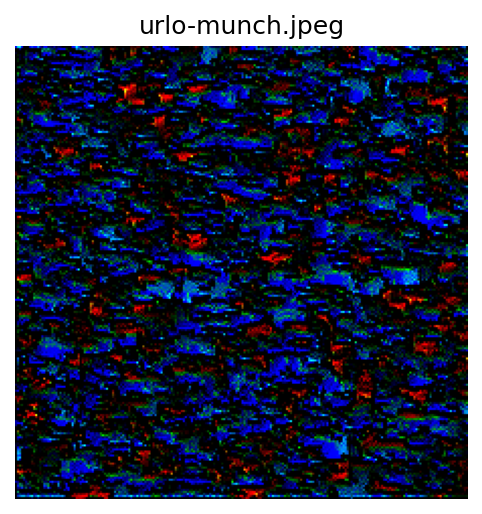

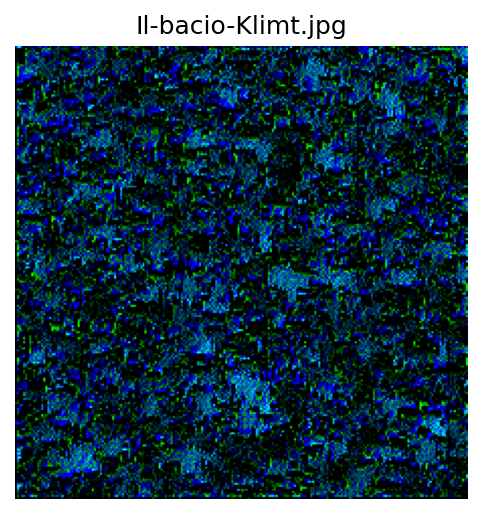

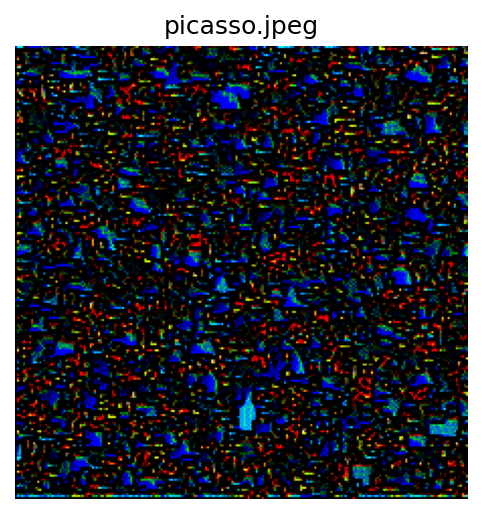

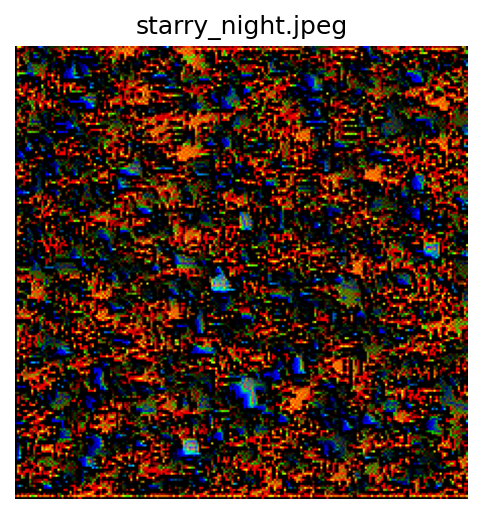

In [3]:
layers_list = ['block1_conv1']


references = [ 
    'style_transfer/urlo-munch.jpeg', 
    'style_transfer/Il-bacio-Klimt.jpg', 
    'style_transfer/picasso.jpeg' ,
    'style_transfer/starry_night.jpeg'
]

for reference_image_path in references:
    # Create a new model that extracts the style features

    style_extractor = tf.keras.Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer(name).output for name in layers_list])

    reference_image = tf.keras.preprocessing.image.load_img(reference_image_path, target_size=(224, 224))
    reference_image = tf.keras.preprocessing.image.img_to_array(reference_image)
    reference_image = np.expand_dims(reference_image, axis=0)

    # Extract style from the reference image
    reference_style = extract_style(reference_image)

    # Generate an image with the extracted style
    stylized_image = generate_image_with_style(reference_style)

    # Display the stylized image
    plt.figure(dpi=150)
    plt.imshow(stylized_image[0] / 255.0)
    plt.title(reference_image_path.split("/")[1])
    plt.axis('off')
    plt.show()


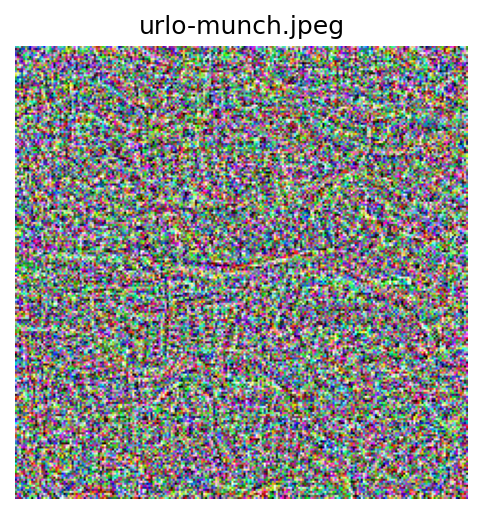

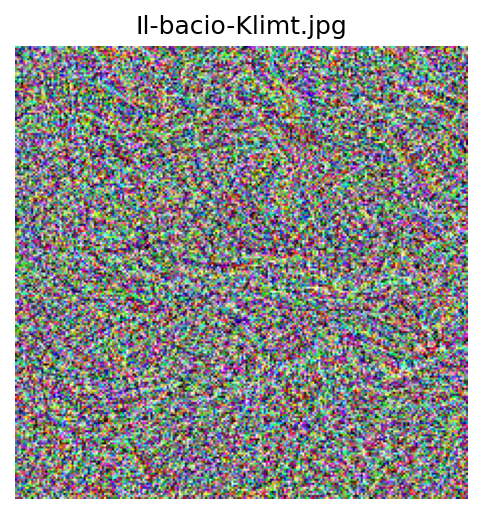

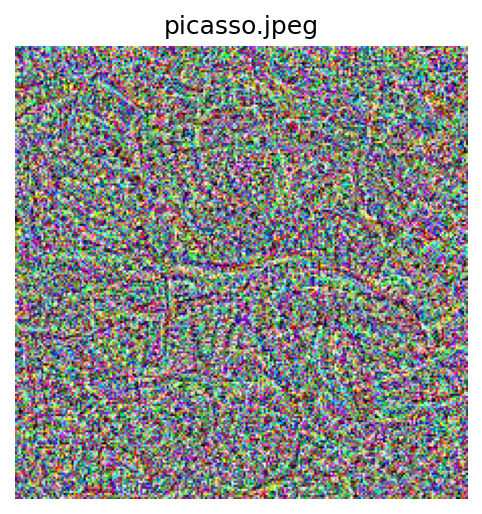

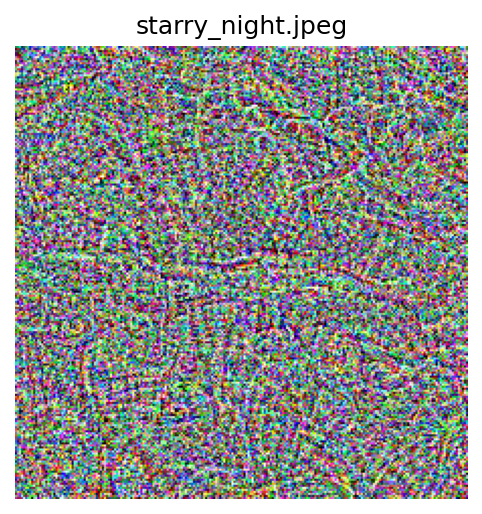

In [4]:
layers_list = ['block5_conv1']
references = [ 
    'style_transfer/urlo-munch.jpeg', 
    'style_transfer/Il-bacio-Klimt.jpg', 
    'style_transfer/picasso.jpeg' ,
    'style_transfer/starry_night.jpeg'
]

for reference_image_path in references:
    style_extractor = tf.keras.Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer(name).output for name in layers_list])
    
    reference_image = tf.keras.preprocessing.image.load_img(reference_image_path, target_size=(224, 224))
    reference_image = tf.keras.preprocessing.image.img_to_array(reference_image)
    reference_image = np.expand_dims(reference_image, axis=0)

    # Extract style from the reference image
    reference_style = extract_style(reference_image)

    # Generate an image with the extracted style
    stylized_image = generate_image_with_style(reference_style)

    # Display the stylized image
    plt.figure(dpi=150)
    plt.imshow(stylized_image[0] / 255.0)
    plt.title(reference_image_path.split("/")[1])
    plt.axis('off')
    plt.show()


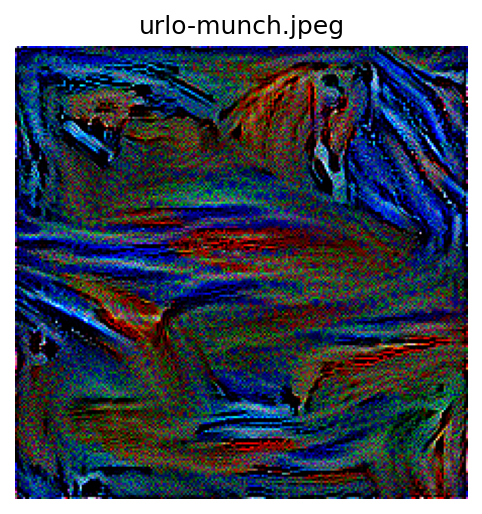

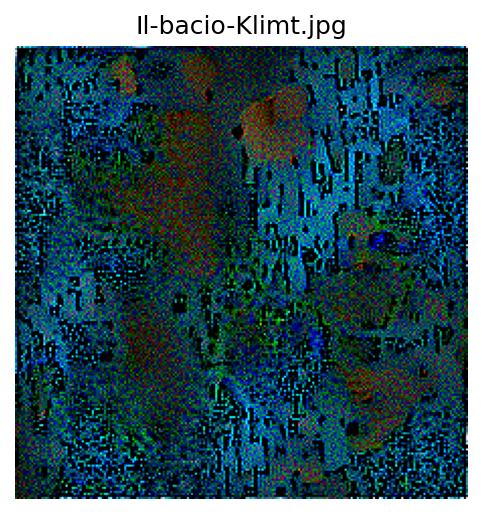

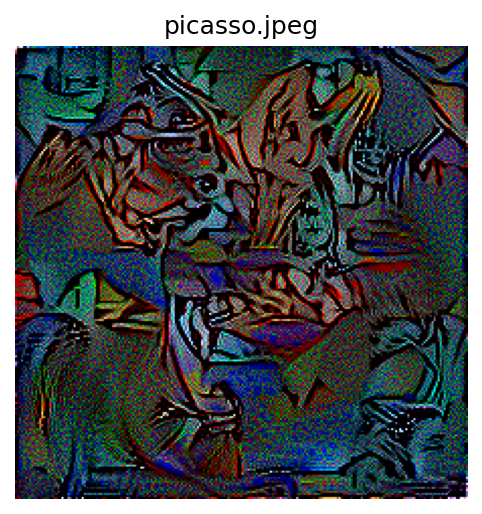

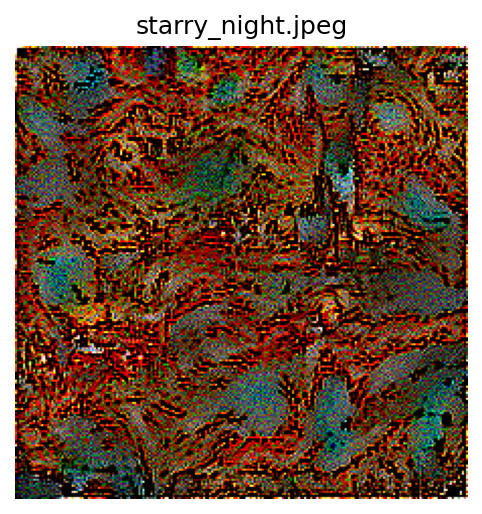

In [5]:
layers_list = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
references = [ 
    'style_transfer/urlo-munch.jpeg', 
    'style_transfer/Il-bacio-Klimt.jpg', 
    'style_transfer/picasso.jpeg' ,
    'style_transfer/starry_night.jpeg'
]

for reference_image_path in references:
    style_extractor = tf.keras.Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer(name).output for name in layers_list])
    
    reference_image = tf.keras.preprocessing.image.load_img(reference_image_path, target_size=(224, 224))
    reference_image = tf.keras.preprocessing.image.img_to_array(reference_image)
    reference_image = np.expand_dims(reference_image, axis=0)

    # Extract style from the reference image
    reference_style = extract_style(reference_image)

    # Generate an image with the extracted style
    stylized_image = generate_image_with_style(reference_style)

    # Display the stylized image
    plt.figure(dpi=150)
    plt.imshow(stylized_image[0] / 255.0)
    plt.title(reference_image_path.split("/")[1])
    plt.axis('off')
    plt.show()
